# Table of Contents
1. Introduction
2. Problem Statement
3. Motivation
4. Background Research
5. Data
6. Research Questions
7. Methodologies
8. Analysis
    1. Q1
    2. Q2
    3. Q3
    4. Q4
9. Conclusion
    1. Implications
    2. COncluding Comments

# Introduction

The content, tone, and format of job bulletins can influence the quality of the applicant pool. Overly-specific job requirements may discourage diversity. The Los Angeles Mayor’s Office has provided data for a Kaggle Competition to identify improvements needed in hiring process.

# Problem Statement

The goal is to analyze job postings to:

- (1) identify language that can negatively bias the pool of applicants
- (2) analyze the diversity and quality of the applicant pool

# Motivation

The rationale behind choosing this project was to understand if gender neutral job postings exist. I thougt it would be interesting to do a content and language analysis of these job postings.

I also wanted to undestand if job postings deter diversity.

# Background Research

Source: [Harvard Business Review](https://www.hbs.edu/recruiting/blog/post/simple-ways-to-take-gender-bias-out-of-your-jobs)


Use of gendered language can deter certain applicants from applying to job postings. A few years ago, social scientists at the University of Waterloo and Duke University coded a long list of adjectives and verbs as masculine or feminine then scanned a popular job site to look for those words. They found (pdf) that job ads in male-dominated fields (like software programming) tended to use masculine-coded words such as “competitive” and “dominate” much more than job ads in female-dominated fields. Follow-up research confirmed such words made those job listings less appealing to women.

Souce: [Textio Blog on Harmful Writing in Hiring Content](https://textio.com/blog/avoiding-harmful-language-in-hiring-content/34152146534)
    
Hiring content sometimes contains inadvertant use of harmful language. One example is using the term **minorities** to refer to **non-white** racial and ethnic groups collectively. This term can be degrading because it is typically associated with deficiency and inferiority. Instead of using minorities, which is also simply inaccurate in many contexts, consider using **people of color** or **underrepresented** groups.

According to this [LinkedIn post](https://business.linkedin.com/talent-solutions/blog/job-descriptions/2018/5-must-dos-for-writing-inclusive-job-descriptions, an ideal inclusive job description contains the following attributes:

- Avoid gender-coded words, like “rockstar,” “ninja,” and “dominate”
- Limit your job requirements to “must-haves”
- Avoid using unnecessary corporate speak and jargon
- Emphasize your company’s commitment to diversity and inclusion
- Call out inclusive benefits like parental leave and childcare subsidies

# Data

Source: https://www.kaggle.com/c/data-science-for-good-city-of-los-angeles/data

The job bulletins will be provided as a folder of plain-text files, one for each job classification.

Job Bulletins [Folder]

- 683 plain-text job postings

Instructions and Additional Documents [Folder]

- Job Bulletins with Annotations
- Job_titles.csv

# Research Questions

Question 1: Does genedered language exist in Job Decriptions? 

Question 2: How gendered is the language across various job roles?

Question 3: Does managerial roles have more gendered tone in their descriptions?

Question 4: Does the presence of gendered text influence salary of the jobs?

# Methodologies

The first question can be done by analyzing the corpus and finding the number of genderered keywords in the job descriptions. Continuing with the second and thord question, we can repeat the same analysis over different job roles to find out what roles have more prevalence of using biased language in their hiring content. I also calculated a gender-neutral score for all descriptions using the following formula.

Gender Neutral Score = Total num. of MGW - Total num. of FGW

For the last question, I used linear regression to model the salaries as a function of num. of MGW  and num. of FGW.

# Analysis

In [1]:
#Uncomment to Download Packages
"""
!pip install textstat
!python -m spacy download en_core_web_sm
!pip install wordcloud
"""

'\n!pip install textstat\n!python -m spacy download en_core_web_sm\n!pip install wordcloud\n'

In [2]:
#Load Libraries

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from pylab import *

from nltk.corpus import stopwords 
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from string import punctuation

import textstat, spacy, nltk 
import pandas as pd, os
import numpy as np 
import string, re
import random
import en_core_web_sm

from constants import *
import operator

np.random.seed(0)

#Load NLTK lists

In [3]:
nlp = en_core_web_sm.load()
punct = list(punctuation)
stop_words = set(stopwords.words("english"))

#Read Data

In [4]:
structured_df = pd.read_csv(structured_path)

 This helper fucntion creates the barplots

In [5]:

def create_count_plot(_dict, _color, _title, end_thresh=100, offset = 50, font_size = 15, rev = False, _range = False, start_thresh= 0, _ylab= 'Words', _xlab = 'Word Frequency'):
    if _range:
        _dict = {key: value for key, value in _dict.items() if value in range(start_thresh, end_thresh)}
    else:
        _dict = {key: value for key, value in _dict.items() if value >= end_thresh}

    sorted_dict = sorted(_dict.items(), key=operator.itemgetter(1), reverse = rev)  

    plt.figure(figsize=(10,8))

    names = [sorted_dict[item][0] for item in range(len(sorted_dict))]
    values = [sorted_dict[item][1] for item in range(len(sorted_dict))]


    pos = arange(len(sorted_dict))+1

    barh(pos, values, align = 'center', color = _color)
    yticks(pos,(names))

    for i, v in enumerate(values):
        text(v + 3, i + .25, str(v), fontweight = 'bold', fontsize = font_size)
    xlim(start_thresh, max(_dict.values())+offset)

    title('Histogram of {} Keywords'.format(_title))
    xlabel(_xlab)
    ylabel(_ylab)
    plt.savefig('figures/Histogram of {} Keywords.png'.format(_title))


    show()

#Helper Function to populate title metadata

In [6]:
def populate_title_metadata(title):
    for manager_keyword in manager_keywords:
        if manager_keyword in title:
            return 1
        else:
            return 0

 Helper Function to populate gendered list

In [7]:
def populate_gendered_keywords(master_list, master_dict, txt):
    total_kwds = 0
    for keywrd in master_list:
        masc_count = txt.count(" "+keywrd.lower()+" ")
        if masc_count > 0:
            total_kwds += masc_count
            if keywrd in master_dict.keys():
                master_dict[keywrd] =  masc_count + master_dict[keywrd]
            else:
                master_dict[keywrd] =  masc_count
    return master_dict, total_kwds

 Helper Function to populate job info

In [8]:
def populate_job_info(fname):
    file_df = structured_df[structured_df["FILE_NAME"] == fname]
    if len(file_df) > 0:
        salary = file_df['ENTRY_SALARY_GEN'].iloc(0)[0]
        title = file_df['JOB_CLASS_TITLE'].iloc(0)[0]

        if 'to' in salary:
            start_sal, end_sal = salary.split()[0], salary.split()[2]
        else:
            start_sal, end_sal = salary.split()[0], salary.split()[0]

    else:
        title= ""
        start_sal = "0"
        end_sal = "0"

    return title.strip().lower(), start_sal.strip().replace("$","").replace("*","").replace(",","").replace(".",""), end_sal.strip().replace("$","").replace("*","").replace(",","").replace(".","")


 Helper funtion to clean text

In [9]:
def clean_text(fname):
    txt = open(base_path + fname).read()
    txt = " ".join(txt.split("\n"))
    tokens = word_tokenize(txt.lower())
    lower_tokens = [token.lower() for token in tokens]
    cleaned_tokens = [token for token in lower_tokens if token not in stop_words and token not in punctuation]
    txt = " ".join(cleaned_tokens)
    txt = " "+txt.lower()+" "
    
    return txt

  Prepare Data

  Step 1: Prepare the data
  This cell iterates over all the job description files and extracts the following, 
  1. Count dictionary of superlatives
  2. Count dictionary of masculine gendered keywords
  3. Count dictionary of feminine gendered keywords
  4. If the job is managerial or not
  5. Salary of the job
  6. Title of the job
  7. Gender Neutral Score = Total num. of MGW - Total num. of FGW

In [10]:
masc_count_dict = {}
fem_count_dict = {}
sup_count_dict = {}

results = []

for fname in os.listdir(base_path):
    if fname == "POLICE COMMANDER 2251 092917.txt":
        continue
        
    result = {}
    
    txt = clean_text(fname)

    result['title'], result['end_sal'], result['start_sal'] = populate_job_info(fname)
    
    result['is_managerial_role'] = populate_title_metadata(result['title'])
    
    masc_count_dict, total_masc_kwds = populate_gendered_keywords(masculine_keywords, masc_count_dict, txt)
    fem_count_dict, total_fem_kwds = populate_gendered_keywords(feminine_keywords, fem_count_dict, txt)
    sup_count_dict, total_sup_kwds = populate_gendered_keywords(superlative_keywords, sup_count_dict, txt)
    result['num_masc_keywords'] = total_masc_kwds
    result['num_fem_keywords'] = total_fem_kwds
    result['num_sup_keywords'] = total_sup_kwds
    
    result['kwrd_diff'] = total_masc_kwds - total_fem_kwds
    
    results.append(result)


  Step2: This step creates a data frame from the above dictionry
  columns are as follows: 
  1. num_sup_keywords:  Count dictionary of superlatives
  2. num_masc_keywords: Count dictionary of masculine gendered keywords
  3. num_fem_keywords Count dictionary of feminine gendered keywords
  4. is_role_managerial: If the job is managerial or not
  5. start_sal : starting Salary of the job
  6. end_sal : max Salary of the job
  7. title: Title of the job
  8. kwrd_diff: Gender Neutral Score = Total num. of MGW - Total num. of FGW

In [11]:
df = pd.DataFrame.from_dict(results, orient='columns')
df['end_sal'] = np.where(df['end_sal']== '-', 0, df['end_sal'])
df['end_sal'] = np.where(df['end_sal']== '', 0, df['end_sal'])
df['end_sal'] = (df['end_sal']).astype(int)

df['start_sal'] = np.where(df['start_sal']== '-', 0, df['start_sal'])
df['start_sal'] = np.where(df['start_sal']== '', 0, df['start_sal'])
df['start_sal'] = (df['start_sal']).astype(int)
df = df.loc[df['title'] != ""]

 Step 3: Creates an aggregated dataframe from the master dataframe

In [12]:
agg_df = df.groupby('title').agg({'end_sal': 'mean', 
                         'start_sal': 'mean', 
                         'num_masc_keywords':'sum',
                        'num_fem_keywords':'sum',
                        'num_sup_keywords':'sum',
                        'kwrd_diff': 'sum'})

 Step 4: Creates a subset of data from Step 3 containing only the managerial roles

In [13]:
manager_df = df[df['is_managerial_role']==1]

  # Question 1: Does genedered language exist in Job Decriptions? 

   WordCloud of Masculine Gendered Keywords

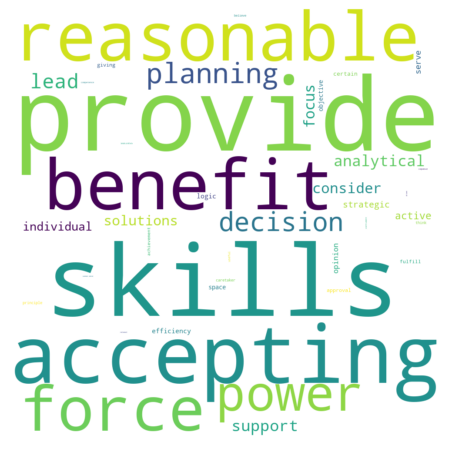

In [14]:
plt.figure(figsize=(10,8))
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(masc_count_dict)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('figures/MGW_Word_Cloud.png')
plt.show()

   WordCloud of Feminine Gendered Keywords

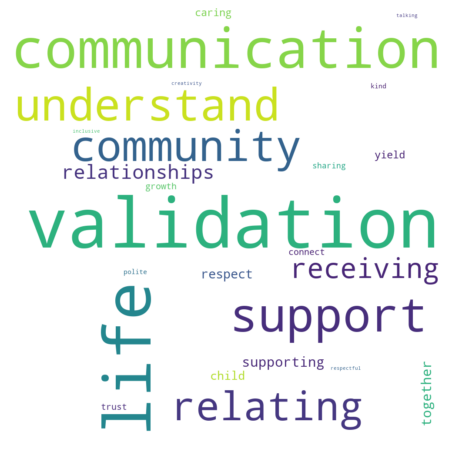

In [15]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(fem_count_dict)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('figures/FGW_Word_Cloud.png')
plt.show()

   WordCloud of Superlative Keywords

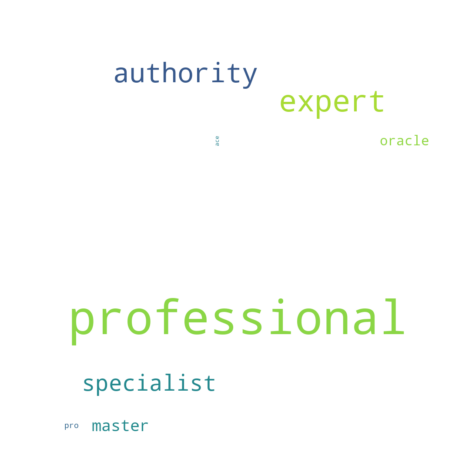

In [16]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(sup_count_dict)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.savefig('figures/Siperlatives_Word_Cloud.png')
plt.show()

   Barplot of Most Occuring Masculine Gendered Keywords

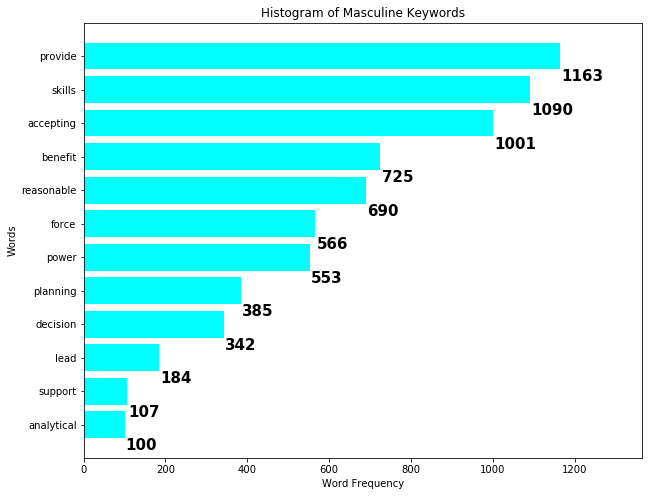

In [17]:
create_count_plot(masc_count_dict, 'cyan', 'Masculine', 100, 200)

   Barplot of Most Occuring Feminine Gendered Keywords

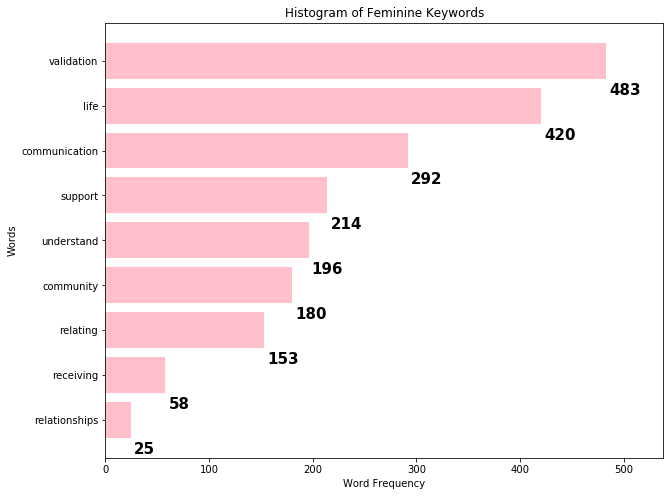

In [18]:
create_count_plot(fem_count_dict, 'pink', 'Feminine', 20, 55)

   Barplot of Most Occuring Superlative Keywords

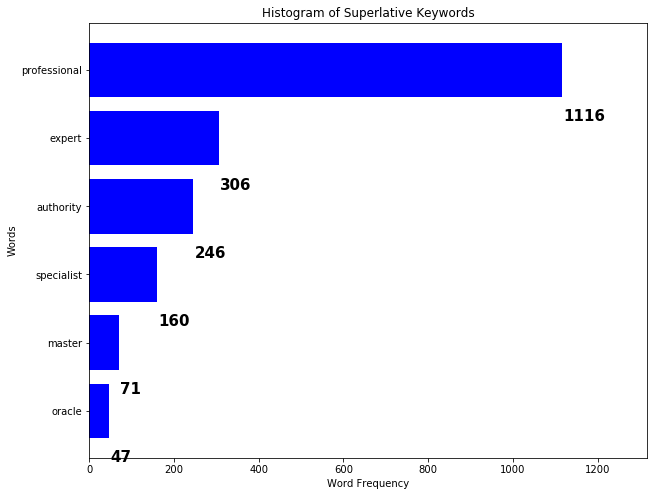

In [19]:
create_count_plot(sup_count_dict, 'blue', 'Superlative', 10, 200)

   Conclusion

In [20]:
print("Number of job descriptions with no male gendered words :", len(df[df['num_masc_keywords']==0]))
print("Number of job descriptions with no male gendered words :", len(df[df['num_fem_keywords']==0]))
print("Number of job descriptions with no superlative words :", len(df[df['num_sup_keywords']==0]))

Number of job descriptions with no male gendered words : 0
Number of job descriptions with no male gendered words : 35
Number of job descriptions with no superlative words : 142


###    All the job descriptions have gendered keywords. Job descriptions tend to have more masculine gendered keywords, than female gendered keywords. Not a lot of superlatives are used in the job descriptions.

#  Question 2: How gendered is the language across various job roles?

   Barplot of Masculine Gendered Descriptions Across Job Roles

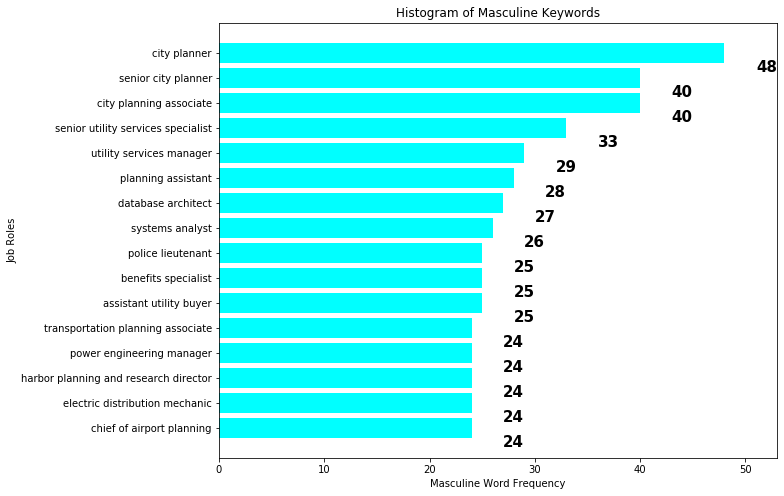

In [21]:
masc_df = agg_df['num_masc_keywords'].to_dict()
  
create_count_plot(masc_df, 'cyan', 'Masculine', 24, 5, 15, False, False, 0, 'Job Roles', _xlab = 'Masculine Word Frequency')

   Barplot of Feminine Gendered Descriptions Across Job Roles

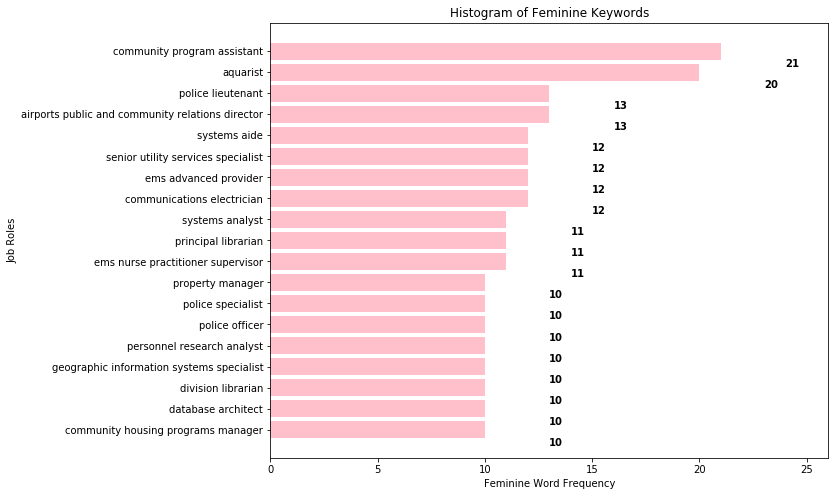

In [22]:
fem_df = agg_df['num_fem_keywords'].to_dict()
create_count_plot(fem_df, 'pink', 'Feminine', 10, 5, 10, _ylab= 'Job Roles', _xlab = 'Feminine Word Frequency')

   Barplot of Gender Neutral Descriptions Across Job Roles

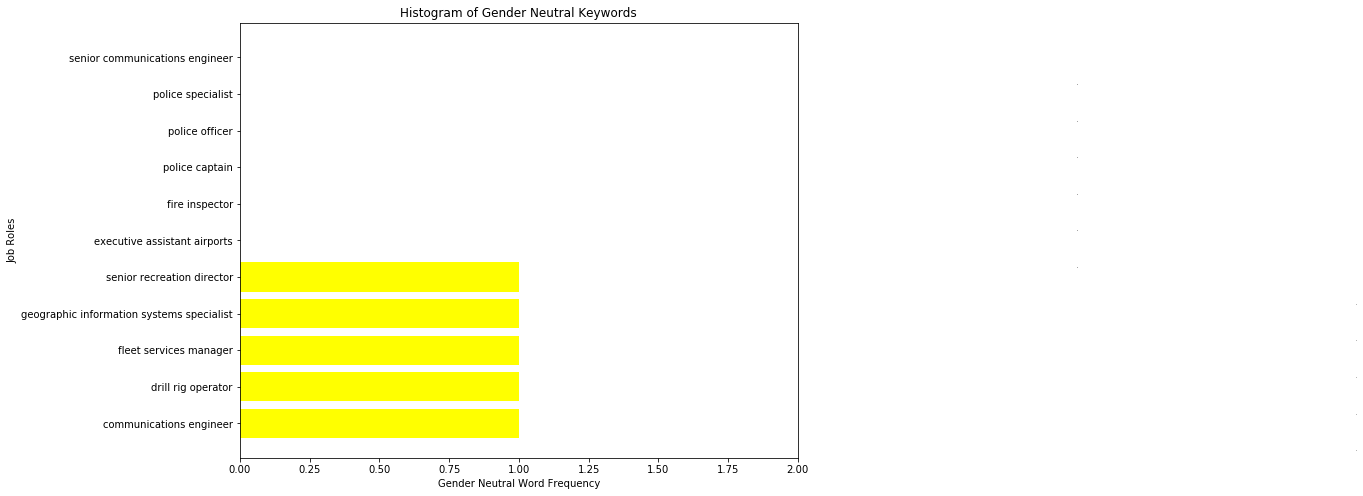

In [23]:
gn_df = agg_df['kwrd_diff'].to_dict()
create_count_plot(gn_df, 'yellow', 'Gender Neutral', 2, 1, True, True, -2, _ylab= 'Job Roles', _xlab = 'Gender Neutral Word Frequency')

   Conclusion

In [24]:
print("Number of average masculine gendered words in a job description ", np.mean(df['num_masc_keywords']))
print("Number of average feminine gendered words in a job description ", np.mean(df['num_fem_keywords']))

Number of average masculine gendered words in a job description  10.981452859350851
Number of average feminine gendered words in a job description  3.0401854714064913


   We can conclude that job descriptions contain more masculine gendered keywords. Almost thrice the amount of feminine keywords. 

  Question 3: Does managerial roles have more gendered tone in their descriptions?

In [25]:
print("Number of average masculine gendered words in a managerial job description ", np.mean(manager_df['num_masc_keywords']))
print("Number of average feminine gendered words in a managerial job description ", np.mean(manager_df['num_fem_keywords']))

Number of average masculine gendered words in a managerial job description  10.204301075268818
Number of average feminine gendered words in a managerial job description  2.881720430107527


## Conclusion
### We can observe that managerial positions have even fewer feminine gendered keywords.

  # Question 4: Does the presence of gendered text influence salary of the jobs?


  Create Data for Regression

In [26]:
data = df.copy(deep=True)
data['avg_salary'] = (data['start_sal'] + data['end_sal'])/2
data.drop(['title', 'start_sal', 'end_sal'], axis =1)

,is_managerial_role,num_masc_keywords,num_fem_keywords,num_sup_keywords,kwrd_diff,avg_salary
0,0,8,2,1,6,86312.0
1,0,5,1,2,4,118843.0
2,0,11,6,9,5,71607.5
3,0,15,5,6,10,80241.5
4,0,15,1,1,14,106080.0
...,...,...,...,...,...,...
676,0,9,1,4,8,112313.0
677,0,9,2,1,7,89585.5
678,0,13,1,3,12,57492.5
679,0,11,4,0,7,77882.0


  Histogram of salary

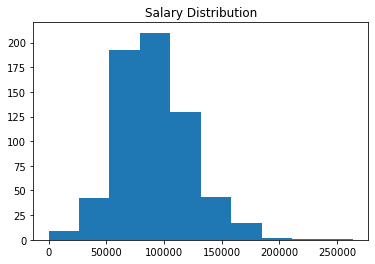

In [27]:
hist(data['avg_salary'])
plt.title("Salary Distribution")
plt.savefig('figures/SalaryHistogram.png')
plt.show()

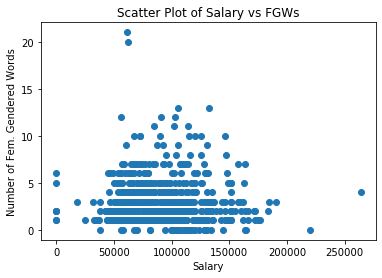

In [28]:
plt.scatter(data['avg_salary'], data['num_fem_keywords'])
plt.xlabel("Salary")
plt.ylabel("Number of Fem. Gendered Words")
plt.title("Scatter Plot of Salary vs FGWs")
plt.savefig('figures/Scatter Plot of Salary vs FGWs.png')
plt.show()

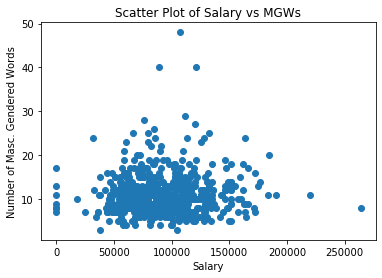

In [29]:
plt.scatter(data['avg_salary'], data['num_masc_keywords'])
plt.xlabel("Salary")
plt.ylabel("Number of Masc. Gendered Words")
plt.title("Scatter Plot of Salary vs MGWs")
plt.savefig('figures/Scatter Plot of Salary vs MGWs.png')
plt.show()

In [30]:
import statsmodels.api as sm
import numpy as np

Y = data['avg_salary']
X = data[['num_masc_keywords', 'num_fem_keywords', 'num_sup_keywords', 'is_managerial_role']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_salary   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     12.47
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           8.99e-10
Time:                        04:02:20   Log-Likelihood:                -7615.6
No. Observations:                 647   AIC:                         1.524e+04
Df Residuals:                     642   BIC:                         1.526e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8.668e+04   3311

#  Conclusion

   The association between the FGWs and salary is significant with a p value of 0.03 and coefficient of ~ -1150. 

  ## Implication

   Fighting bias with bias?

My background research showed that women and men respond to different keywords. Here, we are generelizing that women like certain words more than others and so do men. So, the question that comes to mind is whether to make job descriptions more gender neutral, do we make certain assumptions about the genders. And if we do, should we track the changes to these psychological affiliaions.

  # Concluding Comments

There exists gendered word usage across the job board. We have them in descriptions for all the roles. More masculine words are used than feminine words. The gap seem to become wider when we analysed managerial roles. More feminine words are associated with decreased salary but this result needs more investigation because while we got significant p-values for our regression analysis, the overall F-1 statistic of the test was not significant. 